# Reliable Signal Propagation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import copy
import numpy as np
from scipy.signal import find_peaks
import scipy.fftpack
from matplotlib import pyplot as plt
import seaborn as sns
import time
import torch

from src.network import Layer, PropagationNetwork, FullyConnectedLayerApprox, FullyConnectedLayerTorched, PropagationNetworkFCTorched
from src.ou_process import ouprocess_gaussian
from src.experiment import Experiment, MultiVariableExperiment
from src.lif import gaussian_kernel

sns.set()

(This notebook contains the code for _____ )

Transmit a *common* signal through biologically realistic feed-forward networks (BrFNN) is a non-trivial problem. In this notebook, and corresponding paper, we show how the synaptic weight representation for a network doing this task can be reduced from an $N*N$ matrix to an $N*1$ vector.

*./src* contains the core code for the BrFNNs, while this notebook contains our analysis of the behaviour of the reduced synaptic weight model and the full synaptic weight model

In [2]:
def default_style():
    sns.set(style="white")
    sns.set_context("talk", font_scale=1.0)
    plt.rc('axes',edgecolor='#FFFFFF')

def graph_psth(spikes, num_timesteps, save=None, color="#2598B2", title=None, xlabel=None, ylabel=None):
    graph_size = 5
    sns.set(style="white")
    sns.set_context("talk", font_scale=1.0)

    plt.figure(figsize=(graph_size, graph_size))
    plt.rc('axes',edgecolor='#FFFFFF')

    in_spike_inds, in_spike_trial = np.where(spikes[:num_timesteps] > 0)
    in_spike_inds = in_spike_inds / float(num_timesteps)

    plt.scatter(in_spike_inds, in_spike_trial, s=6, marker='o', c=color)
    
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    if save is not None:
        plt.savefig(save)
    else:
        plt.show()
    plt.close()
    
    default_style()

def graph_firing_rates(in_fr, out_fr, num_timesteps, save=None, in_color="#888888", out_color='#189B48'):
    sns.set(style="white")
#     sns.set_context("talk", font_scale=2.5)
    plt.rc('axes',edgecolor='#FFFFFF')

    t = np.arange(0, 1.0, 1e-4)

    plt.figure(figsize=(5,4))
    plt.ylim(top=60)

    plt.plot(t, in_fr.mean(1).numpy()[:num_timesteps], c=in_color, lw=5.0)
    plt.plot(t, out_fr.mean(1).numpy()[:num_timesteps], c=out_color, lw=5.0)

    sns.despine()
    
    if save is not None:
        plt.savefig(save)
    else:
        plt.show()
    plt.close()
    
    default_style()

In [3]:
NUM_NEURONS = 200
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 30.0e3
test_t_stop = 5000.0

INP_OU_TAU = 50.0

RESULTS_DIR = "./results"
GRAPHS_DIR = "./graphs"

default_style()

BLUE = '#3b668a'

We attempt to transmit a 

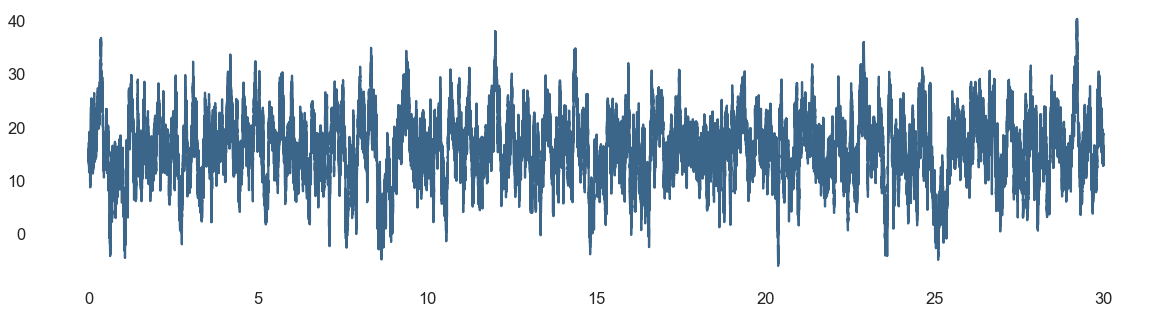

In [30]:
# INPUT: Slow Signal
start_time = time.time()

t = np.arange(0, t_stop * 1.0e-3, 1.0e-4)
input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

plt.figure(figsize=(20,5))
plt.plot(t, i_inj, color=BLUE)
# plt.title("Train Input: OUProcess")
# plt.xlabel("t (sec)")
# plt.ylabel("Current (pA)")
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-training-inp.png")))

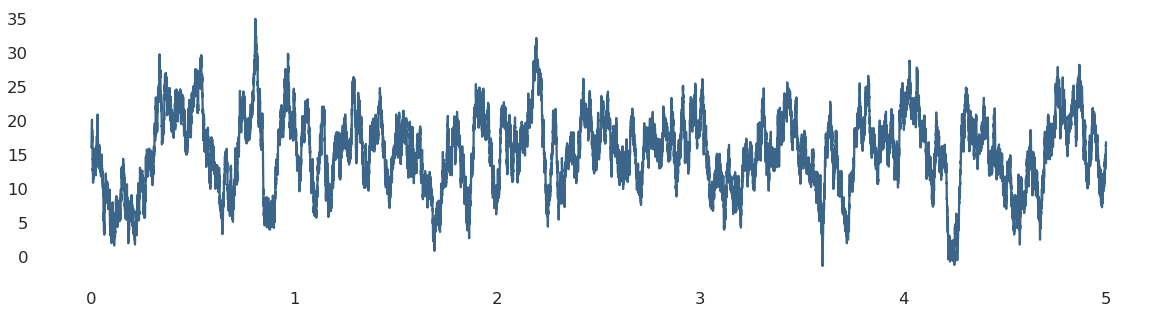

In [4]:
test_t = np.arange(0, test_t_stop * 1.0e-3, 1.0e-4)

test_input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, test_t_stop, 1)
test_i_inj = 16.0 + 6.0*test_input_slow

plt.figure(figsize=(20,5))
plt.plot(test_t, test_i_inj, color=BLUE)
# plt.title("Test Input: OUProcess")
# plt.xlabel("t (sec)")
# plt.ylabel("Current (pA)")
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-test-inp.png")))

# Reduced Synaptic Weight Model

In [32]:
LOAD_LAYER = True
load_ieee_reducednet_cf_file = "ieee_rednet_cf__neurons=200__trials=200__input=tau_" + str(INP_OU_TAU) + "_regenerated__t_stop=5000_msecs"

if LOAD_LAYER:
    experiment = Experiment.load(RESULTS_DIR, load_ieee_reducednet_cf_file)
    layer = experiment.layer
else:
    layer = Layer(NUM_NEURONS)
    layer.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)
#     layer.save()

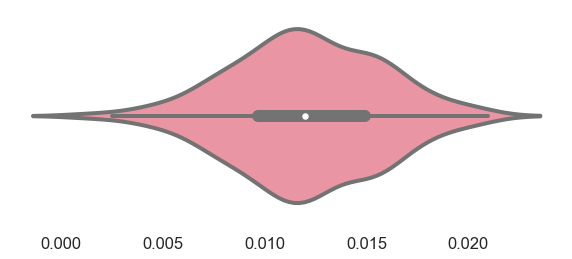

In [34]:
# Weight Distribution

plt.figure(figsize=(10,4))

sns.violinplot(layer.W, linewidth=4, color=sns.xkcd_rgb["rose pink"])
# plt.title("Synaptic Weight Distribution")
# plt.xlabel("Weight (pA/mV)")
# plt.savefig((os.path.join(GRAPHS_DIR, "rednet_weights.png")))
# plt.show()
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-rednet-weights.png")))

In [35]:
start_time = time.time()
out, V, F_binary, F_synaptic = layer.output(test_i_inj, dt, test_t_stop)
_, spike_out = layer.spike(out, dt, test_t_stop, int_noise_regen=True)
print(time.time() - start_time)

18.796128273010254


In [36]:
start_time = time.time()
in_fr = layer.firing_rate(F_binary, dt, test_t_stop)
out_fr = layer.firing_rate(spike_out, dt, test_t_stop)
print(time.time() - start_time)

321.53333711624146


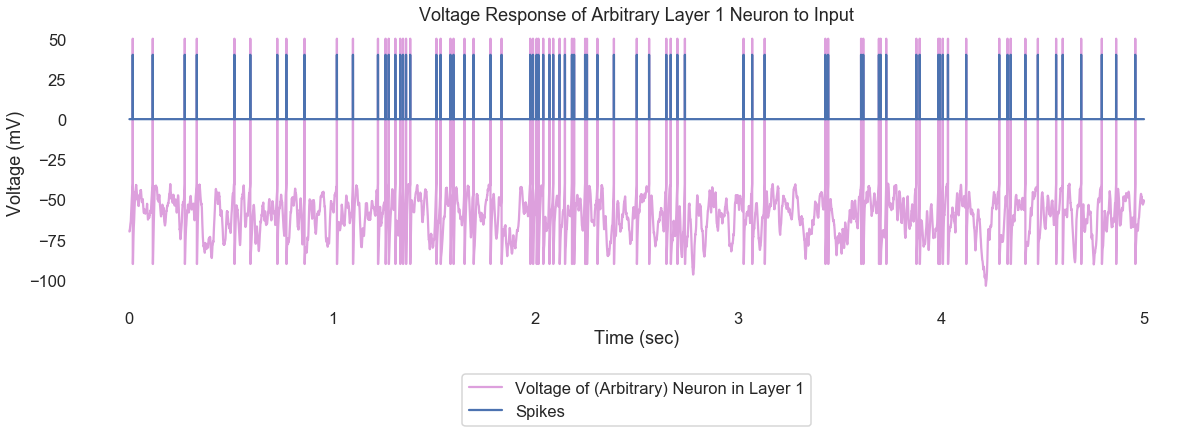

In [37]:
# Voltage + Spike graph
neuron_ind = 10
t_i = 0
t_f = len(test_t)

plt.figure(figsize=(20,5))
plt.plot(test_t, V[t_i:t_f, neuron_ind], color='plum', label="Voltage of (Arbitrary) Neuron in Layer 1")
plt.plot(test_t, F_binary[t_i:t_f, neuron_ind] * 40.0, label="Spikes")
plt.title("Voltage Response of Arbitrary Layer 1 Neuron to Input")
plt.xlabel("Time (sec)")
plt.ylabel("Voltage (mV)")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
# TODO: LEGEND
plt.show()

In [42]:
# graph_psth(F_binary, 10000, title="Input Firing", xlabel="Time (sec)", ylabel="Neuron Index", save=(os.path.join(GRAPHS_DIR, "ieee-rev-verif_rednet_input_spikes.png")))
graph_psth(F_binary, 10000, title=None, xlabel=None, ylabel=None, save=(os.path.join(GRAPHS_DIR, "ieee-rev-verif_rednet_input_spikes.png")))

In [44]:
# graph_psth(spike_out, 10000, title="Output Firing", xlabel="Time (sec)", ylabel="Neuron Index"), save=(os.path.join(GRAPHS_DIR, "ieee-rev-verif_rednet_output_spikes.png"))
graph_psth(spike_out, 10000, title=None, xlabel=None, ylabel=None, save=(os.path.join(GRAPHS_DIR, "ieee-rev-verif_rednet_output_spikes.png")))

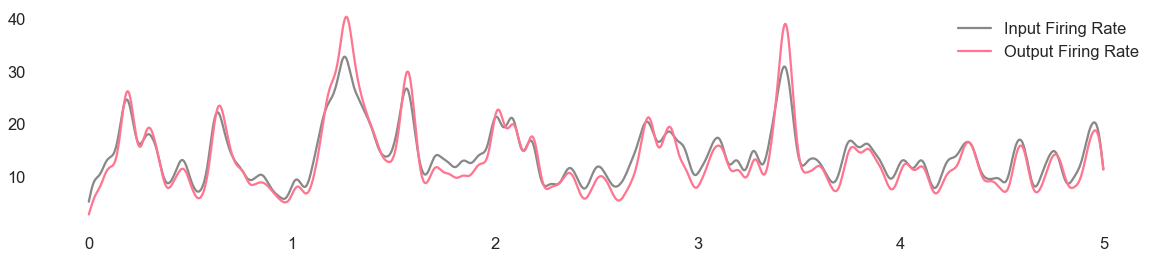

In [49]:
# sns.set(style="white")
# sns.set_context("talk", font_scale=1.5)
# plt.rc('axes',edgecolor='#666666')

plt.figure(figsize=(20,4))
plt.plot(test_t, in_fr.mean(1).numpy(), "#888888", label="Input Firing Rate")
plt.plot(test_t, out_fr.mean(1).numpy(), '#FF7590', label="Output Firing Rate")

# plt.title("Propagation of Signal (Reduced Network): Inst. Firing Rate")
# plt.xlabel("Time (s)")
# plt.ylabel("Inst. Firing Rate (Hz)")
plt.legend(edgecolor="white")

sns.despine()

# plt.show()
plt.savefig((os.path.join(GRAPHS_DIR, "iee-rev-fig4c-fr-redn_unc.png")))

In [50]:
LOAD_IEEE_REDUCEDNET_CF = False
load_ieee_reducednet_cf_file = "ieee_rednet_cf__neurons=200__trials=200__input=tau_" + str(INP_OU_TAU) + "_regenerated__t_stop=5000_msecs"

In [53]:
if LOAD_IEEE_REDUCEDNET_CF:
    experiment = Experiment.load(RESULTS_DIR, load_ieee_reducednet_cf_file)
else:
    NUM_TRIALS = 200
    test_t_stop = 5000.0

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    exp_inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        exp_input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, test_t_stop, 1)
        exp_i_inj = 16.0 + 6.0*exp_input_slow
        exp_inputs[:,i] = exp_i_inj.flatten()

    experiment = Experiment(exp_inputs, layer, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_ieee_reducednet_cf_file)

Trial  0
10  Iter time:  5.724331855773926
Total time:  5.725327968597412


Trial  10
10  Iter time:  54.463372230529785
Total time:  60.189698457717896


Trial  20
10  Iter time:  54.321025371551514
Total time:  114.51271796226501


Trial  30
10  Iter time:  54.23389267921448
Total time:  168.7466106414795


Trial  40
10  Iter time:  59.59581637382507
Total time:  228.34442377090454


Trial  50
10  Iter time:  55.409263372421265
Total time:  283.7546851634979


Trial  60
10  Iter time:  61.369224071502686
Total time:  345.1239092350006


Trial  70
10  Iter time:  52.739200830459595
Total time:  397.8631100654602


Trial  80
10  Iter time:  59.97930550575256
Total time:  457.84341382980347


Trial  90
10  Iter time:  55.685683727264404
Total time:  513.5290975570679


Trial  100
10  Iter time:  55.68145394325256
Total time:  569.21156001091


Trial  110
10  Iter time:  59.586881160736084
Total time:  628.8025591373444


Trial  120
10  Iter time:  55.330103635787964
Total time:  684.132

In [54]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

np.savez(os.path.join(RESULTS_DIR, "iee-rev-rednet-cfs.npz"))

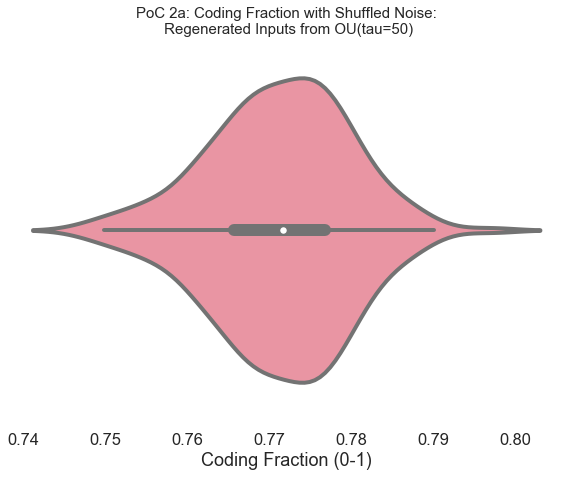

In [55]:
plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_ieee_reducednet_cf_file + ".png"))

# Full Synaptic Weight Model: Verification

In [5]:
LOAD_LAYER = True
load_layer_file = "fcl_neurons=200"

GPU_MODE = "gpu" # Change to "cpu" if you want to use CPU

test_t_stop = 5000.0

if LOAD_LAYER:
    fcl = FullyConnectedLayerTorched.load(RESULTS_DIR, load_layer_file, device=GPU_MODE)
else:
    fcl = FullyConnectedLayerTorched(NUM_NEURONS, std_noise=25.0, device=GPU_MODE)
    fcl.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)
    fcl.save(RESULTS_DIR, load_layer_file)

start_time = time.time()
fcl_out, fcl_V, fcl_F_binary, fcl_F_synaptic = fcl.output(test_i_inj, dt, test_t_stop)
_, fcl_spike_out = fcl.spike(fcl_out, dt, test_t_stop, int_noise_regen=True)
print(time.time() - start_time)

55.263705015182495


In [6]:
start_time = time.time()
fcl_in_fr = fcl.firing_rate(fcl_F_binary, dt, test_t_stop)
fcl_out_fr = fcl.firing_rate(fcl_spike_out, dt, test_t_stop)
print(time.time() - start_time)

106.80141925811768


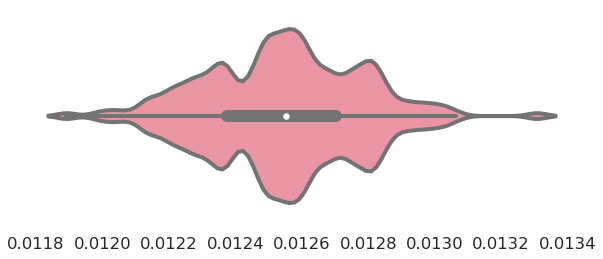

In [8]:
# Weight Distribution

plt.figure(figsize=(10,4))

sns.violinplot(fcl.W, linewidth=4, color=sns.xkcd_rgb["rose pink"])
# plt.title("Synaptic Weight Distribution")
# plt.xlabel("Weight (pA/mV)")
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-fcl_weights.png")))
# plt.show()

In [9]:
# graph_psth(fcl_F_binary, 10000, title="Input Firing", xlabel="Time (sec)", ylabel="Neuron Index") # (os.path.join(GRAPHS_DIR, "verif_fcl_approx_input_spikes.png")
graph_psth(fcl_F_binary, 10000, title=None, xlabel=None, ylabel=None, save=(os.path.join(GRAPHS_DIR, "ieee_rev_verif_fcl_approx_input_spikes.png")))

In [10]:
# graph_psth(fcl_spike_out, 10000, title="Output Firing", xlabel="Time (sec)", ylabel="Neuron Index") # (os.path.join(GRAPHS_DIR, "verif_fcl_approx_output_spikes.png"))
graph_psth(fcl_spike_out, 10000, title=None, xlabel=None, ylabel=None, save=(os.path.join(GRAPHS_DIR, "ieee_rev_verif_fcl_approx_output_spikes.png")))

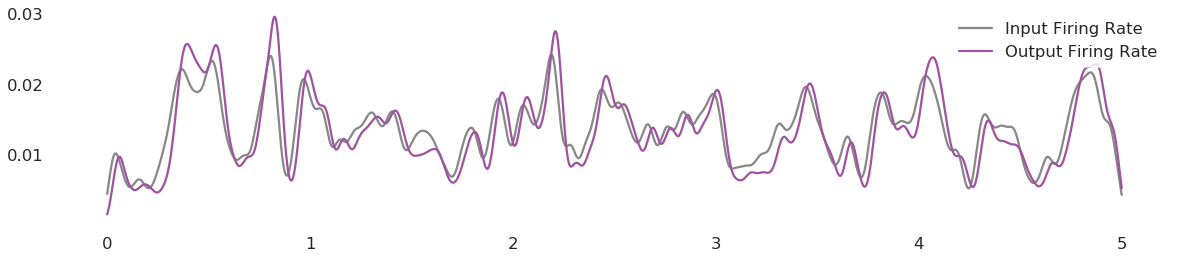

In [13]:
# sns.set(style="white")
# sns.set_context("talk", font_scale=1.5)
# plt.rc('axes',edgecolor='#666666')

plt.figure(figsize=(20,4))
plt.plot(test_t, fcl_in_fr.mean(1).numpy(), "#888888", label="Input Firing Rate")
plt.plot(test_t, fcl_out_fr.mean(1).numpy(), '#a053a0', label="Output Firing Rate")

# plt.title("Propagation of Signal (Reduced Network): Inst. Firing Rate")
# plt.xlabel("Time (s)")
# plt.ylabel("Inst. Firing Rate (Hz)")

sns.despine()
plt.legend(edgecolor="white")

plt.show()
# plt.savefig((os.path.join(GRAPHS_DIR, "fig4c-fr-redn_unc.png")))

In [6]:
LOAD_IEEE_FCL_CF = True
load_ieee_fcl_cf_file = "ieee_fcl_cf__neurons=200__trials=200__input=tau_" + str(INP_OU_TAU) + "_regenerated__t_stop=5000_msecs"

In [7]:
if LOAD_IEEE_FCL_CF:
    experiment = Experiment.load(RESULTS_DIR, load_ieee_fcl_cf_file)
else:
    NUM_TRIALS = 200
    test_t_stop = 5000.0

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    exp_inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        exp_input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, test_t_stop, 1)
        exp_i_inj = 16.0 + 6.0*exp_input_slow
        exp_inputs[:,i] = exp_i_inj.flatten()

    experiment = Experiment(exp_inputs, fcl, NUM_TRIALS, dt, test_t_stop, num_neurons=NUM_NEURONS)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_ieee_fcl_cf_file)

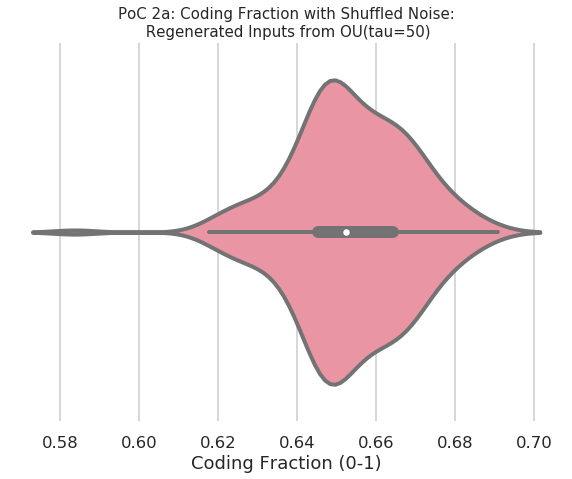

In [8]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(np.average(experiment.outputs[:, i], axis=1)-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_poc_2a_file + ".png"))